# MSCA 32018 Natural Language Processing and Cognitive Computing
## Final Project - Sentiment Analysis
### Customized model on open-source data

Shijia Huang

-----

In [1]:
#!pip install -r requirements.txt

In [2]:
# Import basic libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

In [4]:
# Import NLP libraries
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pprint import pprint
import string
from rake_nltk import Rake

import eli5
import pickle

import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
spacy.prefer_gpu()
print(spacy.__version__)

import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim as gensimvis
#import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

2023-05-20 16:24:30.413693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3.5.2


In [5]:
# Import sklearn libraries
import sklearn
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [6]:
import multiprocessing as mp

num_processors = mp.cpu_count()
print(f'Available CPUs: {num_processors}')

Available CPUs: 12


### Read Cleaned New Articles

In [7]:
%%time

# GCP version
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_filtered.parquet', engine='pyarrow')
df_news.shape

CPU times: user 1min 14s, sys: 25.5 s, total: 1min 40s
Wall time: 2min 37s


(154283, 10)

In [8]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154283 entries, 0 to 154282
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                154283 non-null  int64 
 1   date              154283 non-null  object
 2   cleaned title     154283 non-null  object
 3   cleaned text      154283 non-null  object
 4   title_tokens      154283 non-null  object
 5   title_lemmatized  154283 non-null  object
 6   text_tokens       154283 non-null  object
 7   text_lemmatized   154283 non-null  object
 8   title_keywords    154283 non-null  object
 9   text_keywords     154283 non-null  object
dtypes: int64(1), object(9)
memory usage: 11.8+ MB


In [9]:
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]"
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, next, happen, 

In [10]:
### SAMPLE DATA
# df_news = df_news.sample(frac=0.1, random_state=2023)
df_news.shape

(154283, 10)

In [11]:
%%time

# save sample data as parquet file
# path = "gs://nlp-final-project-data/sample/"
# df_news.to_parquet(path + 'news_sampled.parquet', engine='pyarrow')

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.06 µs


## Data Preparation

### Load Open Source Data
Public Perception of AI Dataset: https://www.kaggle.com/datasets/saurabhshahane/public-perception-of-ai

In [12]:
df_ai_news = pd.read_csv('gs://nlp-final-project-data/data/robot-ai-all-public.csv')
df_ai_news.shape

(17073, 27)

In [13]:
df_ai_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17073 entries, 0 to 17072
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Article ID                 17073 non-null  object
 1   Article Date               9129 non-null   object
 2   Paragraph number           17073 non-null  object
 3   NYT section                17061 non-null  object
 4   Paragraph                  17061 non-null  object
 5   Title                      17070 non-null  object
 6   WorkTimeInSeconds          17073 non-null  int64 
 7   AI Mood                    17073 non-null  int64 
 8   AI Relevance               17073 non-null  int64 
 9   Fiction                    17073 non-null  int64 
 10  Controling AI (negative)   17073 non-null  int64 
 11  Cyborg (negative)          17073 non-null  int64 
 12  Ethics (negative)          17073 non-null  int64 
 13  Military (negative)        17073 non-null  int64 
 14  Progre

In [14]:
df_ai_news.head(2)

,Article ID,Article Date,Paragraph number,NYT section,Paragraph,Title,WorkTimeInSeconds,AI Mood,AI Relevance,Fiction,Controling AI (negative),Cyborg (negative),Ethics (negative),Military (negative),Progress (negative),Singularity (negative),Work (negative),Other (negative),Cyborg (positive),Decisions (positive),Education (positive),Entertain (positive),Healthcare (positive),Singularity (positive),Transportation (positive),Work (positive),Other (positive)
0,4fd1cbc98eb7c8105d701286,1996-10-06 00:00:00 UTC,18,New York and Region,"Thus, next weekend will feature the robot who is named Sico (pronounced SEE-co). ''He can speak seven languages,'' Ms. Finkel said, ''and he interacts. Whatever language you speak he can speak.'' Of course he has never spoken to a Long Islander. No one is quite sure how he will interpret the Long Island accent.",LONG ISLAND JOURNAL,1472,4,5,0,0,0,0,0,0,0,0,{},0,0,0,0,0,0,0,0,{}
1,4fd1cbc98eb7c8105d701286,1996-10-06 00:00:00 UTC,18,New York and Region,"Thus, next weekend will feature the robot who is named Sico (pronounced SEE-co). ''He can speak seven languages,'' Ms. Finkel said, ''and he interacts. Whatever language you speak he can speak.'' Of course he has never spoken to a Long Islander. No one is quite sure how he will interpret the Long Island accent.",LONG ISLAND JOURNAL,49,4,5,0,0,0,0,0,0,0,0,{},0,0,0,0,0,0,0,0,{}


### Data Preprocessing

In [15]:
# check for null values
df_ai_news.isnull().sum()

Article ID                      0
Article Date                 7944
Paragraph number                0
NYT section                    12
Paragraph                      12
Title                           3
WorkTimeInSeconds               0
AI Mood                         0
AI Relevance                    0
Fiction                         0
Controling AI (negative)        0
Cyborg (negative)               0
Ethics (negative)               0
Military (negative)             0
Progress (negative)             0
Singularity (negative)          0
Work (negative)                 0
Other (negative)                0
Cyborg (positive)               0
Decisions (positive)            0
Education (positive)            0
Entertain (positive)            0
Healthcare (positive)           0
Singularity (positive)          0
Transportation (positive)       0
Work (positive)                 0
Other (positive)                0
dtype: int64

In [16]:
# drop null text values
df_ai_news.dropna(subset=['Paragraph'], inplace=True)

# drop columns with too many null values
df_ai_news.drop(columns=['Article Date', 'WorkTimeInSeconds'], inplace=True)

# drop duplicate texts
df_ai_news.drop_duplicates(subset=['Paragraph'], inplace=True)

# Phrase paragraph as string
df_ai_news['Paragraph'] = df_ai_news['Paragraph'].astype(str)

df_ai_news.shape

(4940, 25)

In [17]:
# Basic statistics
df_ai_news.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
AI Mood,4940.0,3.271,0.816,1.0,3.0,3.0,4.0,5.0
AI Relevance,4940.0,3.822,1.262,1.0,3.0,4.0,5.0,5.0
Fiction,4940.0,0.077,0.266,0.0,0.0,0.0,0.0,1.0
Controling AI (negative),4940.0,0.025,0.155,0.0,0.0,0.0,0.0,1.0
Cyborg (negative),4940.0,0.005,0.074,0.0,0.0,0.0,0.0,1.0
Ethics (negative),4940.0,0.006,0.080,0.0,0.0,0.0,0.0,1.0
Military (negative),4940.0,0.016,0.125,0.0,0.0,0.0,0.0,1.0
Progress (negative),4940.0,0.026,0.159,0.0,0.0,0.0,0.0,1.0
Singularity (negative),4940.0,0.008,0.087,0.0,0.0,0.0,0.0,1.0
Work (negative),4940.0,0.013,0.113,0.0,0.0,0.0,0.0,1.0


In [18]:
df_ai_news.head(2)

,Article ID,Paragraph number,NYT section,Paragraph,Title,AI Mood,AI Relevance,Fiction,Controling AI (negative),Cyborg (negative),Ethics (negative),Military (negative),Progress (negative),Singularity (negative),Work (negative),Other (negative),Cyborg (positive),Decisions (positive),Education (positive),Entertain (positive),Healthcare (positive),Singularity (positive),Transportation (positive),Work (positive),Other (positive)
0,4fd1cbc98eb7c8105d701286,18,New York and Region,"Thus, next weekend will feature the robot who is named Sico (pronounced SEE-co). ''He can speak seven languages,'' Ms. Finkel said, ''and he interacts. Whatever language you speak he can speak.'' Of course he has never spoken to a Long Islander. No one is quite sure how he will interpret the Long Island accent.",LONG ISLAND JOURNAL,4,5,0,0,0,0,0,0,0,0,{},0,0,0,0,0,0,0,0,{}
3,54b0793b7988100e21965770,16,Technology,"That phrase was coined in the 1970۪s by Masahiro Mori, the Japanese robotics specialist, as he sought to describe the emotional response of humans to robots and other nonhuman entities. He theorized that as a robot became more lifelike, the emotional response of humans became increasingly positive and empathetic until a certain point at which the robot took on a zombie-like quality, and the human response turned to repulsion. Then, as the robot becomes indistinguishable from a human, the re...",Camera System Creates Sophisticated 3-D Effects,3,4,0,0,0,0,0,0,0,0,{},0,0,0,0,0,0,0,0,{}


### Text Cleaning

In [19]:
# function to remove special characters from a sentence
def remove_spc_char(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9 @ . , : - _]', '', text)
    return cleaned_text

In [20]:
# function to tokenize text into words and remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

In [21]:
# function to remove stopwords from list of tokens
stop_words = stopwords.words('english')

def remove_stopwords(texts):
    cleaned_texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    return cleaned_texts


In [22]:
# function to make ngrams from original tokens
def make_bigrams(texts_wstops):
    bigram = gensim.models.Phrases(texts_wstops, min_count=1, threshold=3)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    texts_nostops = remove_stopwords(texts_wstops)
    return [bigram_mod[doc] for doc in texts_nostops]

def make_trigrams(texts_wstops):
    bigram = gensim.models.Phrases(texts_wstops, min_count=1, threshold=3)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts_wstops], threshold=1)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    texts_nostops = remove_stopwords(texts_wstops)
    return [trigram_mod[bigram_mod[doc]] for doc in texts_nostops]

In [23]:
# function to lemmatize words
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [24]:
%%time

# remove special characters
para_cleaned = np.array(df_ai_news['Paragraph'].apply(lambda x: remove_spc_char(x)))

# tokenize the paragraphs
para_tokens = list(sent_to_words(para_cleaned))

# remove stopwords
para_token_nostops = remove_stopwords(para_tokens)

# make bigrams and trigrams
para_bigrams = make_bigrams(para_tokens)
para_trigrams = make_trigrams(para_tokens)

# combine tokens and ngrams
df_ai_news['para_tokens'] = list(zip(para_token_nostops, para_bigrams, para_trigrams))
df_ai_news['para_tokens'] = df_ai_news['para_tokens'].apply(lambda x: list(x[0] + x[1] + x[2]))
para_tokens_all = df_ai_news['para_tokens'].tolist()

CPU times: user 8.76 s, sys: 80.8 ms, total: 8.84 s
Wall time: 8.85 s


In [25]:
%%time

# lemmatize the tokens keeping only noun, adj, vb, adv
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
para_lemmatized = lemmatization(para_tokens_all, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN'])

df_ai_news['para_lemmatized'] = para_lemmatized
df_ai_news[['Paragraph', 'para_tokens', 'para_lemmatized']].head()

CPU times: user 55.4 s, sys: 3.68 s, total: 59.1 s
Wall time: 59.1 s


,Paragraph,para_tokens,para_lemmatized
0,"Thus, next weekend will feature the robot who is named Sico (pronounced SEE-co). ''He can speak seven languages,'' Ms. Finkel said, ''and he interacts. Whatever language you speak he can speak.'' Of course he has never spoken to a Long Islander. No one is quite sure how he will interpret the Long Island accent.","[thus, next, weekend, feature, robot, named, sico, pronounced, seeco, speak, seven, languages, ms, finkel, said, interacts, whatever, language, speak, speak, course, never, spoken, long, islander, one, quite, sure, interpret, long, island, accent, thus, next, weekend, feature, robot_named, sico, pronounced, seeco, speak, seven, languages, ms_finkel, said, interacts, whatever, language, speak, speak, course, never, spoken, long, islander, one, quite_sure, interpret, long_island, accent, thus,...","[thus, next, weekend, feature, robot, name, sico, pronounced, seeco, speak, language, ms, finkel, say, interact, language, speak, speak, course, never, speak, long, islander, quite, sure, interpret, long, island, accent, thus, next, weekend, feature, robot_name, sico, pronounced, seeco, speak, language, say, interact, language, speak, speak, course, never, speak, long, islander, quite_sure, interpret, long_island, accent, thus, next, weekend, feature, robot_name, sico, pronounced, seeco, spe..."
3,"That phrase was coined in the 1970۪s by Masahiro Mori, the Japanese robotics specialist, as he sought to describe the emotional response of humans to robots and other nonhuman entities. He theorized that as a robot became more lifelike, the emotional response of humans became increasingly positive and empathetic until a certain point at which the robot took on a zombie-like quality, and the human response turned to repulsion. Then, as the robot becomes indistinguishable from a human, the re...","[phrase, coined, masahiro, mori, japanese, robotics, specialist, sought, describe, emotional, response, humans, robots, nonhuman, entities, theorized, robot, became, lifelike, emotional, response, humans, became, increasingly, positive, empathetic, certain, point, robot, took, zombielike, quality, human, response, turned, repulsion, robot, becomes, human, response, turns, positive, critics, quick, point, eerie, look, characters, polar, express, phrase, coined, masahiro_mori, japanese_robotic...","[phrase, coin, masahiro, mori, japanese, robotic, specialist, seek, describe, emotional, response, humans, robots, nonhuman, entities, theorize, robot, become, lifelike, emotional, response, human, become, increasingly, positive, empathetic, certain, point, robot, take, zombielike, quality, human, response, turn, repulsion, robot, become, human, response, turn, positive, critic, quick, point, eerie, look, character, polar, express, phrase, coin, masahiro_mori, japanese_robotic, specialist, s..."
6,"Users can program the robot to clean a swimming pool at regular intervals or use a remote control to steer it by hand. The Polaris 9300xi sells for $1,379.","[users, program, robot, clean, swimming, pool, regular, intervals, use, remote, control, steer, hand, polaris, xi, sells, users, program, robot, clean_swimming, pool, regular_intervals, use, remote_control, steer, hand, polaris_xi, sells, users, program, robot, clean_swimming, pool, regular_intervals, use, remote_control, steer, hand, polaris_xi, sells]","[user, program, robot, clean, swimming, pool, regular, interval, use, remote, control, steer, hand, polaris, xi, sell, user, program, robot, clean_swimme, pool, regular_interval, use, remote_control, steer, hand, polaris_xi, sell, user, program, robot, clean_swimme, pool, regular_interval, use, remote_control, steer, hand, polaris_xi, sell]"
9,"Although ticket sales are roughly even with last year's unimpressive sales, more studios have at least one successful movie. Most of the money last summer was earned by ''Rambo'' ($146 million by Labor Day, the official end of summer), ''Back to the Future'' ($133 mi

### Target Variable

In [26]:
df_ai_news['AI Mood'].value_counts()

AI Mood
3    3174
4     754
5     557
2     383
1      72
Name: count, dtype: int64

In [27]:
# mapping the sentiment values to text
sentiment_map = {'Negative': 1,
                 'Mostly Negative': 2,
                 'Neutral': 3, 
                 'Mostly Positive': 4,
                 'Positive': 5}

sentiment_labels = list(sentiment_map.keys())
sentiment_labels

['Negative', 'Mostly Negative', 'Neutral', 'Mostly Positive', 'Positive']

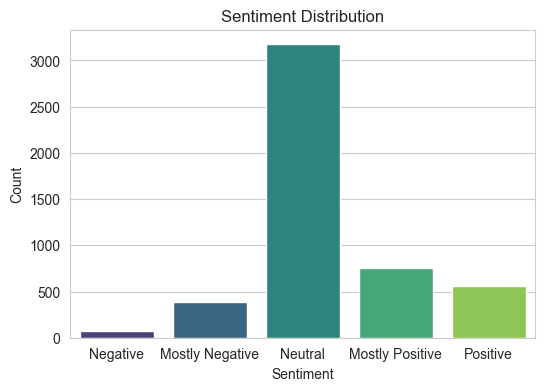

In [28]:
# Visualize the AI Mood distribution
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(x='AI Mood', data=df_ai_news, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(5), labels=sentiment_labels)
plt.show()

## Resample Data to Balance Classes - SMOTE

In [29]:
# convert lemmatized tokens back to string
df_ai_news['para_lemmatized_str'] = df_ai_news['para_lemmatized'].apply(lambda x: ' '.join(x))

In [30]:
# Define X and y
X = df_ai_news['para_lemmatized_str']
y = df_ai_news['AI Mood']

print(f"X Shape: {X.shape}")
print(f"y Shape: {y.shape}")

X Shape: (4940,)
y Shape: (4940,)


### Initialize vectorizer

In [31]:
tfidf = TfidfVectorizer(lowercase=False,
                        ngram_range=(1, 1))

In [32]:
X_vec = tfidf.fit_transform(X)
print(X_vec.shape)

(4940, 32686)


In [33]:
# Access the feature names
feature_names = tfidf.get_feature_names_out()

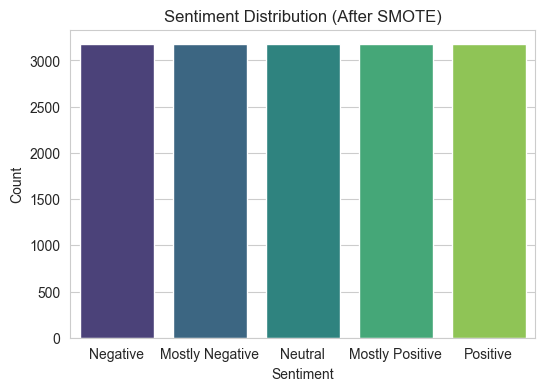

In [34]:
# Apply SMOTE oversampling
sm = SMOTE(random_state=2023)
X_res, y_res = sm.fit_resample(X_vec, y)

# Convert the oversampled data to a dataframe
df_ai_news_res = pd.DataFrame(X_res.toarray(), columns=feature_names)
df_ai_news_res['AI Mood'] = y_res

# Visualize the AI Mood distribution
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(x='AI Mood', data=df_ai_news_res, palette='viridis')
plt.title('Sentiment Distribution (After SMOTE)')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(5), labels=sentiment_labels)
plt.show()

### Train-test split

In [35]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res.toarray(), y_res, test_size=0.2, random_state=2023)

print(f"Training records, X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Testing records, X_test: {X_test.shape} y_test: {y_test.shape}")

Training records, X_train: (12696, 32686) y_train: (12696,)
Testing records, X_test: (3174, 32686) y_test: (3174,)


## Build Customized Model using Open Source Data

### Naive Bayes Model

In [36]:
# Mutinomial Naive Bayes
mnb = MultinomialNB()

In [37]:
# fit the model
%time mnb.fit(X_train, y_train)

CPU times: user 2.24 s, sys: 681 ms, total: 2.92 s
Wall time: 2.01 s


MultinomialNB()

In [38]:
# make class predictions
mnb_pred = mnb.predict(X_test)
mnb_pred[:10]

array([4, 4, 5, 5, 1, 1, 3, 2, 2, 1])

In [39]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {accuracy_score(y_test, mnb_pred) * 100:.1f}%")

Test Accuracy: 85.4%


In [40]:
# calculate precision and recall
print(classification_report(y_test, mnb_pred))

              precision    recall  f1-score   support

           1       0.95      1.00      0.98       624
           2       0.85      0.98      0.91       643
           3       0.97      0.39      0.56       656
           4       0.78      0.94      0.85       625
           5       0.81      0.98      0.89       626

    accuracy                           0.85      3174
   macro avg       0.87      0.86      0.84      3174
weighted avg       0.87      0.85      0.83      3174



In [41]:
# calculate the confusion matrix
print(confusion_matrix(y_test, mnb_pred))

[[624   0   0   0   0]
 [  9 630   1   2   1]
 [ 20  98 257 160 121]
 [  0   8   6 590  21]
 [  2   7   0   6 611]]


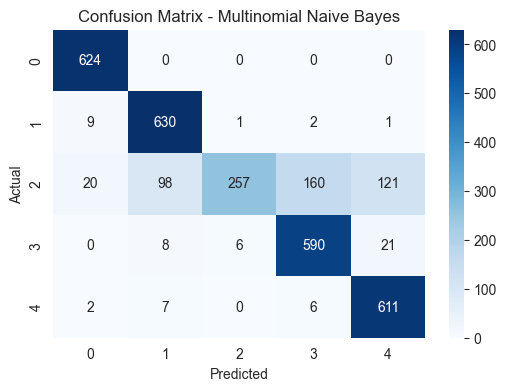

In [42]:
# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, mnb_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multinomial Naive Bayes')
plt.show()

In [43]:
# test for overfitting
mnb_pred_train = mnb.predict(X_train)
print(f"Training Accuracy: {accuracy_score(y_train, mnb_pred_train) * 100:.1f}%")

Training Accuracy: 92.3%


###  Logistic Regression Model

In [44]:
# Logistic Regression model
logreg = LogisticRegression(max_iter=200)

In [45]:
# fit the model
%time logreg.fit(X_train, y_train)

CPU times: user 11min 8s, sys: 46.9 s, total: 11min 55s
Wall time: 2min 6s


LogisticRegression(max_iter=200)

In [46]:
# make class predictions
logreg_pred = logreg.predict(X_test)
logreg_pred

array([4, 4, 5, ..., 4, 4, 1])

In [47]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {accuracy_score(y_test, logreg_pred) * 100:.1f}%")

Test Accuracy: 91.3%


In [48]:
# calculate precision and recall
print(classification_report(y_test, logreg_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       624
           2       0.93      0.98      0.96       643
           3       0.87      0.74      0.80       656
           4       0.87      0.91      0.89       625
           5       0.90      0.94      0.92       626

    accuracy                           0.91      3174
   macro avg       0.91      0.91      0.91      3174
weighted avg       0.91      0.91      0.91      3174



In [49]:
# calculate the confusion matrix
print(confusion_matrix(y_test, logreg_pred))

[[624   0   0   0   0]
 [  2 633   7   1   0]
 [  1  40 483  79  53]
 [  0   5  41 568  11]
 [  1   4  26   4 591]]


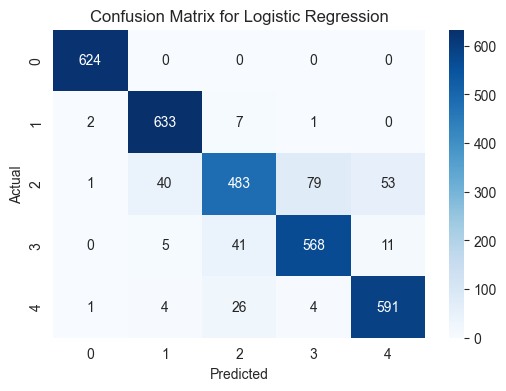

In [50]:
# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, logreg_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [51]:
# test for overfitting
logreg_pred_train = logreg.predict(X_train)
print(f"Training Accuracy: {accuracy_score(y_train, logreg_pred_train) * 100:.1f}%")

Training Accuracy: 97.4%


### Support Vector Machine

In [52]:
# Support Vector Machine model
svm = SGDClassifier(max_iter=100, tol=None)

In [53]:
# fit the model
%time svm.fit(X_train, y_train)

CPU times: user 7min 15s, sys: 3.05 s, total: 7min 18s
Wall time: 7min 20s


SGDClassifier(max_iter=100, tol=None)

In [54]:
# make class predictions
svm_pred = svm.predict(X_test)

In [55]:
# calculate accuracy of class predictions
print(f"Test Accuracy: {accuracy_score(y_test, svm_pred) * 100:.1f}%")

Test Accuracy: 92.5%


In [56]:
# calculate precision and recall
print(classification_report(y_test, svm_pred))

              precision    recall  f1-score   support

           1       0.99      1.00      1.00       624
           2       0.95      1.00      0.97       643
           3       0.94      0.71      0.81       656
           4       0.86      0.95      0.90       625
           5       0.90      0.98      0.94       626

    accuracy                           0.93      3174
   macro avg       0.93      0.93      0.92      3174
weighted avg       0.93      0.93      0.92      3174



In [57]:
# calculate the confusion matrix
print(confusion_matrix(y_test, svm_pred))

[[624   0   0   0   0]
 [  2 640   0   1   0]
 [  2  34 466  95  59]
 [  0   0  25 592   8]
 [  2   1   7   1 615]]


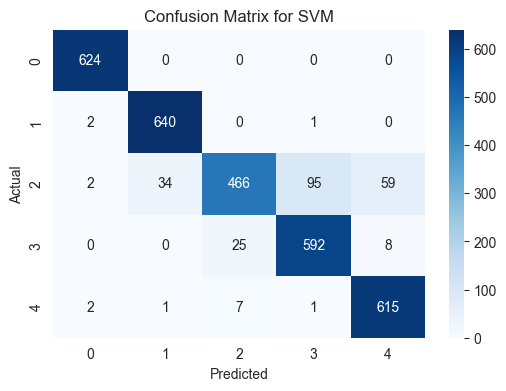

In [58]:
# plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM')
plt.show()

In [59]:
# test for overfitting
svm_pred_train = svm.predict(X_train)
print(f"Training Accuracy: {accuracy_score(y_train, svm_pred_train) * 100:.1f}%")

Training Accuracy: 98.3%


In [60]:
# compare the models
print(f"Multinomial Naive Bayes Test Accuracy: {accuracy_score(y_test, mnb_pred) * 100:.1f}%")
print(f"Logistic Regression Test Accuracy: {accuracy_score(y_test, logreg_pred) * 100:.1f}%")
print(f"SVM Test Accuracy: {accuracy_score(y_test, svm_pred) * 100:.1f}%")

Multinomial Naive Bayes Test Accuracy: 85.4%
Logistic Regression Test Accuracy: 91.3%
SVM Test Accuracy: 92.5%


Based on the result of the three models, I choose the SVM model to predict the sentiment of the news articles.

## Predict Sentiment of News Articles

In [61]:
# convert lemmatized tokens back to string
news_lemmatized_str = df_news['text_lemmatized'].apply(lambda x: ' '.join(x))

# vectorize the text using tfidf
news_vec = tfidf.transform(news_lemmatized_str)

In [62]:
news_vec.toarray().shape

(154283, 32686)

In [63]:
# make predictions
news_pred = svm.predict(news_vec)
news_pred[:10]

array([5, 4, 5, 3, 2, 3, 5, 5, 5, 2])

In [64]:
# add predictions to the dataframe
df_news['sentiment'] = news_pred
df_news.head(2)

,id,date,cleaned title,cleaned text,title_tokens,title_lemmatized,text_tokens,text_lemmatized,title_keywords,text_keywords,sentiment
0,1,2020-02-27,Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot,"Children With Autism Saw Their Learning and Social Skills Boosted After Playing With This AI Robot admin Latest posts by admin see all Mansplaining in conferences: How can we get him to forestall February 27, 2020 Coronavirus Could Explode in the U.S. Overnight Like it Did in Italy February 27, 2020 Levi Strauss marks the next phase in corporate paid leave policies February 27, 2020 Scientists who designed an artificially clever robotic that helped youngsters with autism spice up their ...","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai, robot, children, autism, saw, learning, social, skills, boosted, playing, ai_robot]","[child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, robot, child, autism, see, learn, social, skill, boost, play, ai_robot]","[children, autism, saw, learning, social, skills, boosted, playing, ai, robot, admin, latest, posts, admin, see, mansplaining, conferences, get, forestall, february, coronavirus, could, explode, overnight, like, italy, february, levi, strauss, marks, next, phase, corporate, paid, leave, policies, february, scientists, designed, artificially, clever, robotic, helped, youngsters, autism, spice, studying, social, talents, hope, era, may, future, help, others, developmental, dysfunction, learn, ...","[child, autism, see, learn, social, skill, boost, play, robot, late, post, admin, see, mansplaining, conference, get, explode, overnight, mark, next, phase, corporate, pay, leave, policy, scientist, design, artificially, clever, robotic, help, youngster, autism, spice, study, social, talent, era, future, help, other, developmental, dysfunction, learn, notice, youngster, gentle, average, autism, take, domestic, s, refer, socially, assistive, robotic, name, kiwi, month, accord, commentary, way...","[social, skill, see, play, learn, child, boost, autism, robot, ai_robot]","[robotic, youngster, kid, child, kiwi, market, autism, learn, crew, talent]",5
1,2,2021-03-26,"Forget ML, AI and Industry 4.0 – obsolescence should be your focus","Forget ML, AI and Industry 4.0 obsolescence should be your focus The world entered a new era of accelerated transformation in the last eighteen months that will continue to evolve and press forward for years to come. Most businesses are playing catchup trying to make sense of a new timeline where the ten years that had been set aside for careful planning and implementation of what was coming up next no longer exists. The next is happening now and, regardless of your industry or seniority, t...","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus, forget, ml, ai, industry, obsolescence, focus]","[forget, ml, ai, industry, obsolescence, focus, world, entered, new, era, accelerated, transformation, last, eighteen, months, continue, evolve, press, forward, years, come, businesses, playing, catchup, trying, make, sense, new, timeline, ten, years, set, aside, careful, planning, implementation, coming, next, longer, exists, next, happening, regardless, industry, seniority, status, quo, shifted, better, face, back, invited, attend, pompous, meeting, london, brazilian, embassy, along, selec...","[forget, ai, industry, obsolescence, focus, world, enter, new, era, accelerate, transformation, last, month, continue, evolve, press, forward, year, come, business, play, catchup, try, make, sense, new, timeline, year, set, aside, careful, planning, implementation, come, next, long, exist, ne

In [65]:
df_news['sentiment'].value_counts()

sentiment
5    64525
4    39703
3    35123
2    14759
1      173
Name: count, dtype: int64

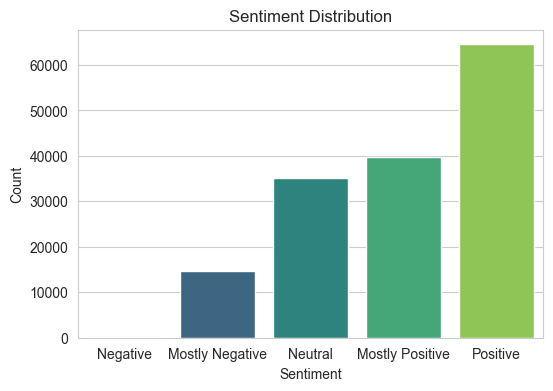

In [66]:
# plot the sentiment distribution
sns.set_style('whitegrid')
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df_news, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=np.arange(5), labels=sentiment_labels)
plt.show()

### Show the prediction result

In [67]:
# randomly select article with sentiment = 5
df_news[df_news['sentiment'] == 5].sample(1).index

Index([3148], dtype='int64')

In [68]:
clf = svm
element = 56787
text = news_lemmatized_str[element]
targets = 5

eli5.show_prediction(clf, doc=text, targets=[targets], vec=tfidf, top=10, feature_names=feature_names)

In [69]:
# randomly select article with sentiment = 5
df_news[df_news['sentiment'] == 1].sample(1).index

Index([105906], dtype='int64')

In [70]:
clf = svm
element = 121165
text = news_lemmatized_str[element]
targets = 5

eli5.show_prediction(clf, doc=text, targets=[targets], vec=tfidf, top=30, feature_names=feature_names)

In [71]:
%%time

# save the dataframe as parquet file
path = "gs://nlp-final-project-data/data/"
df_news.to_parquet(path + 'news_sentiment.parquet', engine='pyarrow')

CPU times: user 1min 32s, sys: 50.3 s, total: 2min 22s
Wall time: 28min 55s


In [72]:
%%time

# Save the fitted vectorizer to a file
filename = 'result/tfidf_vectorizer.pkl'
with open(filename, 'wb') as file:
    pickle.dump(tfidf, file)

print("TF-IDF vectorizer saved locally.")

TF-IDF vectorizer saved locally.
CPU times: user 9.7 ms, sys: 27.4 ms, total: 37.1 ms
Wall time: 65.5 ms


In [73]:
%%time

# Save the model
filename = 'result/svm_sentiment.pkl'
with open(filename, 'wb') as file:
    pickle.dump(svm, file)

print("SVM model saved locally.")

SVM model saved locally.
CPU times: user 2 ms, sys: 9.62 ms, total: 11.6 ms
Wall time: 17.3 ms


## Sentiment Overtime Analysis and Visualization

In [35]:
%%time

# reload the data
path = "gs://nlp-final-project-data/data/"
df_news = pd.read_parquet(path + 'news_sentiment.parquet', engine='pyarrow')

CPU times: user 1min 25s, sys: 45.9 s, total: 2min 11s
Wall time: 3min 14s


In [43]:
# mapping the sentiment values to text
sentiment_map = {'Negative': 1,
                 'Mostly Negative': 2,
                 'Neutral': 3, 
                 'Mostly Positive': 4,
                 'Positive': 5}

sentiment_labels = list(sentiment_map.keys())
sentiment_labels

['Negative', 'Mostly Negative', 'Neutral', 'Mostly Positive', 'Positive']

### Timeline of Sentiment Change

In [44]:
# select the columns to plot
df_plot = df_news[['sentiment', 'date']]
df_plot['date'] = pd.to_datetime(df_plot['date'])
df_plot.head()

,sentiment,date
0,5,2020-02-27
1,4,2021-03-26
2,5,2021-03-10
3,3,2020-10-20
4,2,2020-04-17


In [45]:
# phrase the date column as year-month
df_plot['year-month'] = df_plot['date'].dt.strftime('%Y-%m')
df_plot.head()

,sentiment,date,year-month
0,5,2020-02-27,2020-02
1,4,2021-03-26,2021-03
2,5,2021-03-10,2021-03
3,3,2020-10-20,2020-10
4,2,2020-04-17,2020-04


In [46]:
# group by year-month and sentiment
df_plot_ym = df_plot.groupby(['year-month', 'sentiment']).size().reset_index(name='count')
df_plot_ym.head()

,year-month,sentiment,count
0,2020-01,1,4
1,2020-01,2,282
2,2020-01,3,609
3,2020-01,4,597
4,2020-01,5,1045


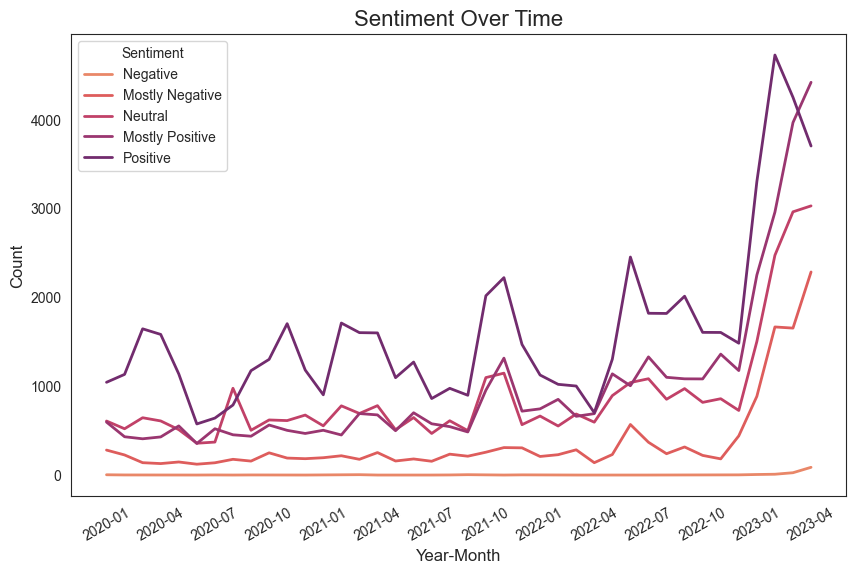

In [47]:
# Plot timeline of the sentiment over time as a line chart

from matplotlib.lines import Line2D

# Set up the color palette
palette = sns.color_palette('flare', len(sentiment_labels))

plt.figure(figsize=(10, 6))
sns.set_style('white')
sns.lineplot(data=df_plot_ym, x='year-month', y='count', hue='sentiment', palette=palette, linewidth=2)
plt.title('Sentiment Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=30)


# Define custom legend handles with consistent line width
custom_handles = [
    Line2D([], [], color=palette[i], linewidth=2, label=sentiment_labels[i])
    for i in range(len(sentiment_labels))
]

plt.legend(title='Sentiment', labels=sentiment_labels, loc='upper left', handles=custom_handles)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15)) # set number of ticks
plt.show()

In [48]:
# group by year-month and calculate the average sentiment
df_plot_avg = df_plot.groupby(['year-month'])['sentiment'].mean().reset_index()
df_plot_avg.head()

,year-month,sentiment
0,2020-01,3.944817
1,2020-02,4.065602
2,2020-03,4.253695
3,2020-04,4.259259
4,2020-05,4.140671


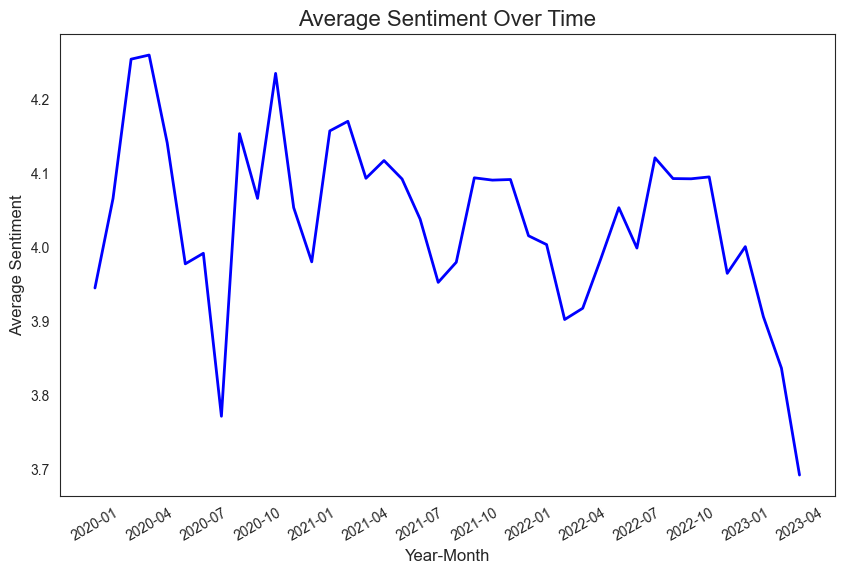

In [49]:
# Plot timeline of average sentiment over time as a line chart
plt.figure(figsize=(10, 6))
sns.set_style('white')
sns.lineplot(data=df_plot_avg, x='year-month', y='sentiment', color='blue', linewidth=2)
plt.title('Average Sentiment Over Time', fontsize=16)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(15)) # set number of ticks
plt.show()